In [1]:
%matplotlib inline

In [2]:
import torch
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score

import numpy as np
import PIL
import random
from IPython.core.display import Image, display

import matplotlib.pyplot as plt

In [3]:
DEVICE_ID = 0
DEVICE = torch.device('cuda:%d' % DEVICE_ID)
torch.cuda.set_device(DEVICE_ID)

In [4]:
### Для запуска без GPU раскомментировать и закоментировать код выше
#DEVICE = torch.device('cpu')

In [5]:
np.random.seed(100500)

def data2image(data):
    res = np.transpose(np.reshape(data ,(3, 32,32)), (1,2,0))
    return PIL.Image.fromarray(np.uint8(res))

def imshow(img):
    if isinstance(img, torch.Tensor): img = img.numpy().astype('uint8')
    plt.imshow(np.transpose(img, (1, 2, 0)))
    
def prediction2classes(output_var):
    _, predicted = torch.max(output_var.data, 1)
    predicted.squeeze_()
    classes = predicted.tolist()
    return classes

def make_solution_pytorch(net, input_tensor, a_batch_size):
    res = []
    net = net.eval()
    cur_pos = 0
    while cur_pos <= len(input_tensor):
        outputs = net(input_tensor[cur_pos:cur_pos+a_batch_size])
        res += prediction2classes(outputs)
        cur_pos += a_batch_size
    return res

In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image

class CifarDataset(Dataset):
    def __init__(self, input_path, is_train=True, transform=None):
                        
        data = np.load(input_path)
        if is_train: 
            self.Y, self.X = np.hsplit(data, [1]) 
            self.Y = [item[0] for item in self.Y]
        else: 
            self.X = data
            self.Y = None
            
        self.X = self.X.reshape((self.X.shape[0], 3, 32, 32))
        self.X = self.X.transpose((0, 2, 3, 1)) #приводим к виду (N, H, W, C)
        self.X = [Image.fromarray(img) for img in self.X]
                
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        
        sample = self.X[idx]

        if self.transform: sample = self.transform(sample)

        if self.Y is None: return sample
        else: return (sample, self.Y[idx])

In [7]:
#Надо поменять пути на свои до файлов с kaggle
#DATA_PATH  = '/home/a.murashev/2018_2/04/kaggle04_files/'
DATA_PATH  = '/home/roma/Desktop/Tehnotrack_NeuralNetworks/4thHW/trainData/'
train_path = 'homework_4.train.npy'
test_path  = 'homework_4_no_classes.test.npy'

In [8]:
np_mean = np.mean([item[0].numpy() for item in CifarDataset(DATA_PATH + train_path, transform=transforms.ToTensor())], axis=(0,2,3))
np_std = np.std([item[0].numpy() for item in CifarDataset(DATA_PATH + train_path, transform=transforms.ToTensor())], axis=(0,2,3))

In [9]:
np_mean.shape

(3,)

In [10]:
cifar_transform_norm = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(torch.FloatTensor(np_mean), torch.FloatTensor(np_std))
]
)

cifar_test_transform_norm = transforms.Compose([    
    transforms.ToTensor(),
    transforms.Normalize(torch.FloatTensor(np_mean), torch.FloatTensor(np_std))
]
)

In [11]:
dataset_train_norm = CifarDataset(DATA_PATH + train_path, transform=cifar_transform_norm)
dataloader_train_norm = DataLoader(dataset_train_norm, batch_size=128,
                        shuffle=True, num_workers=4)

dataset_test_norm = CifarDataset(DATA_PATH + test_path, is_train=False, transform=cifar_test_transform_norm)
dataloader_test_norm = DataLoader(dataset_test_norm, batch_size=128,
                        shuffle=False, num_workers=1)


def train_network(a_net, 
                  a_device,
                  dataloader_train_norm=dataloader_train_norm,
                  a_epochs=164,
                  a_batch_size=128,
                  a_lr=0.1):
    
    train_acc = []
    net = a_net.to(a_device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(a_net.parameters(), lr=a_lr, weight_decay=0.0001, momentum=0.9)

    
    for epoch in range(a_epochs):  # loop over the dataset multiple times
        if epoch == 82:
            optimizer = torch.optim.SGD(a_net.parameters(), lr=a_lr/10, weight_decay=0.0001, momentum=0.9) 
        elif epoch == 123:
            optimizer = torch.optim.SGD(a_net.parameters(), lr=a_lr/100, weight_decay=0.0001, momentum=0.9) 
        
        net = net.train()        
        epoch_accuracy = 0.0
        epoch_iters = 0
        for item in dataloader_train_norm:
            
            epoch_iters += 1

            inputs = item[0].to(a_device)
            labels = item[1].long().to(a_device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_accuracy += accuracy_score(labels, prediction2classes(outputs))

        epoch_accuracy /= epoch_iters
        train_acc.append(epoch_accuracy)
        
        print("Epoch ", epoch, round(train_acc[-1], 4))

    print('Finished Training')
    
    plt.plot(train_acc, label='Train')
    plt.legend()
    plt.grid()

In [12]:
class StupidDenseNet(nn.Module):
    
    def __init__(self):
        super(StupidDenseNet, self).__init__()
        
        #Один из способов задать сеть - это задать последовательность слоев через Sequential
        self.classifier = nn.Sequential()
        self.classifier.add_module('lin1', nn.Linear(3*32*32, 500))
        self.classifier.add_module('sig1', torch.nn.Sigmoid())
        self.classifier.add_module('lin2', nn.Linear(3*32*32, 500))
        self.classifier.add_module('sig2', torch.nn.Sigmoid())
        self.classifier.add_module('lin3', nn.Linear(3*32*32, 500))
        self.classifier.add_module('sig3', torch.nn.Sigmoid())
        
    def forward(self, x):
        x = self.classifier(x)
        return x

In [13]:
class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()

        ### Другой способ задания сети - это описать слои и в forward их применять явно
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        #Увеличиваем кол-во выходных слоев с 84 - до 84*2 - потому что классов 100
        self.fc2 = nn.Linear(120, 84*2)
        self.fc3 = nn.Linear(84*2, 100)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [14]:
"""
class CifarResidualBlock(nn.Module):
    def __init__(self, a_in_channels, make_downsample=False, use_skip_connection=True):
        super(CifarResidualBlock, self).__init__()
        self.use_skip_connection = use_skip_connection
        
        if make_downsample: coef = DOWNSAMPLE_COEF
        else: coef = 1  
            
        ### TODO - нужно описать используемые блоки
        pass
            
    def forward(self, x):
        ###TODO - описать forward блок с учетом флагов make_downsample и use_skip_connection
        return x
"""

'\nclass CifarResidualBlock(nn.Module):\n    def __init__(self, a_in_channels, make_downsample=False, use_skip_connection=True):\n        super(CifarResidualBlock, self).__init__()\n        self.use_skip_connection = use_skip_connection\n        \n        if make_downsample: coef = DOWNSAMPLE_COEF\n        else: coef = 1  \n            \n        ### TODO - нужно описать используемые блоки\n        pass\n            \n    def forward(self, x):\n        ###TODO - описать forward блок с учетом флагов make_downsample и use_skip_connection\n        return x\n'

In [15]:
DOWNSAMPLE_COEF = 2

def conv3x3(a_in_planes, a_out_planes, a_stride=1):
    """
    Основной строительный блок конволюций для ResNet
    Включает в себя padding=1 - чтобы размерность сохранялась после его применения
    """
    return nn.Conv2d(a_in_planes, a_out_planes,  stride=a_stride,
                     kernel_size=3, padding=1, bias=False)

def x_downsample(a_in_channels):
     return nn.Conv2d(a_in_channels, 
               a_in_channels*DOWNSAMPLE_COEF,
               kernel_size=1,
               stride=2,
               bias=False)

In [16]:
class CifarResidualBlock(nn.Module):
    def __init__(self, a_in_channels, make_downsample=False, use_skip_connection=True):
        super(CifarResidualBlock, self).__init__()
        self.use_skip_connection = use_skip_connection
        self.make_downsample     = make_downsample
        
        if make_downsample: coef = DOWNSAMPLE_COEF
        else: coef = 1  
            
        ### TODO - нужно описать используемые блоки
        
        self.DNSPL = x_downsample(a_in_channels)
        
        #self.CONV1 = conv3x3 (a_in_channels, a_in_channels * coef)
        #self.RELU  = nn.ReLU ()
        #self.CONV2 = conv3x3 (a_in_channels * coef, a_in_channels * coef, coef)
        
        
        self.CONV1 = nn.Conv2d(    a_in_channels,
                                   a_in_channels * coef,
                                   kernel_size=3,
                                   stride=1*coef,
                                   padding=1,
                                   bias=False)
        
        self.BNORM1= nn.BatchNorm2d(a_in_channels * coef, eps=1e-05, momentum=0.1, affine=False)
        self.RELU  = nn.ReLU ()
        
        self.CONV2 = nn.Conv2d(    a_in_channels * coef,
                                   a_in_channels * coef,
                                   kernel_size=3,
                                   stride=1,
                                   padding=1,
                                   bias=False)
         
        
        self.BNORM2= nn.BatchNorm2d(a_in_channels * coef, eps=1e-05, momentum=0.1, affine=False)
    def forward(self, x):
        ###TODO - описать forward блок с учетом флагов make_downsample и use_skip_connection
        
        if self.use_skip_connection == True:
            if self.make_downsample == True:
                xprev = self.DNSPL(x)
            else:
                xprev = x
        
        #print ('sizeof(x) = ', x.size())
        #print ('sizeof(xprev) = ', xprev.size())    
        
        x = self.CONV1  (x)
        x = self.BNORM1 (x)
        x = self.RELU   (x)
        
        x = self.CONV2  (x)
        x = self.BNORM2 (x)
        x = self.RELU   (x)
        
        if self.use_skip_connection == True:
            x = xprev + x

        x = self.RELU   (x)
        return x
    

In [17]:
class CifarResNet(nn.Module):
    
    def __init__(self):
        super(CifarResNet, self).__init__()
        
        #TODO нужно добавить блоков resnet и других слоев при необходимости
        
        self.features = nn.Sequential()
        
        #...
        self.features.add_module('firstConv7x7', nn.Conv2d(3, 16, 7, padding=3))
        self.features.add_module('res_block1_1', CifarResidualBlock(16))
        self.features.add_module('res_block1_2', CifarResidualBlock(16))
        self.features.add_module('res_block1_3', CifarResidualBlock(16))
        self.features.add_module('res_DS_1'    , CifarResidualBlock(16, make_downsample=True))
        self.features.add_module('res_block2_1', CifarResidualBlock(32))
        self.features.add_module('res_block2_2', CifarResidualBlock(32))
        self.features.add_module('res_block2_3', CifarResidualBlock(32))
        self.features.add_module('res_DS_2'    , CifarResidualBlock(32, make_downsample=True))
        self.features.add_module('res_block3_1', CifarResidualBlock(64))
        self.features.add_module('res_block3_2', CifarResidualBlock(64))
        self.features.add_module('res_block3_3', CifarResidualBlock(64))
        self.features.add_module('res_DS_3'    , CifarResidualBlock(64, make_downsample=True))
        self.features.add_module('res_block4_1', CifarResidualBlock(128))
        self.features.add_module('res_block4_2', CifarResidualBlock(128))
        self.features.add_module('res_block4_3', CifarResidualBlock(128))
        #4x4
        #...
        
        self.global_avg_pooling = nn.AvgPool2d(kernel_size=4)
        self.fc_classifier = nn.Linear(128, 100)
        
    def forward(self, x):
        x = self.features(x)
        x = self.global_avg_pooling(x)        
        x = x.view((x.size()[0], -1))        
        x = self.fc_classifier(x)        
        return x

In [18]:
#dense_net = StupidDenseNet()
#%time train_network(dense_net, torch.device(DEVICE))

In [19]:
#lenet = LeNet()
#lenet.cuda()
#%time train_network(lenet, torch.device('cpu'), a_epochs=10)

In [20]:
#lenet = LeNet()
#%time train_network(lenet, torch.device(DEVICE), a_epochs=10)
#%time train_network(lenet, a_epochs=10)

Epoch  0 0.0519
Epoch  1 0.0825
Epoch  2 0.0962
Epoch  3 0.0958
Epoch  4 0.102
Epoch  5 0.1014
Epoch  6 0.1078
Epoch  7 0.112
Epoch  8 0.1151
Epoch  9 0.1151
Epoch  10 0.1124
Epoch  11 0.1183
Epoch  12 0.117
Epoch  13 0.1211
Epoch  14 0.1196
Epoch  15 0.1237
Epoch  16 0.1217
Epoch  17 0.1229
Epoch  18 0.1197
Epoch  19 0.1252
Finished Training
CPU times: user 34.2 s, sys: 10.4 s, total: 44.6 s
Wall time: 51.2 s


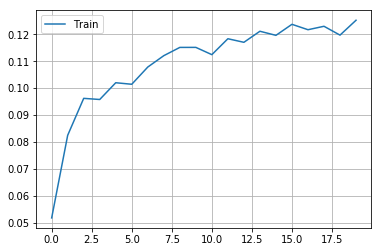

In [21]:
lenet = LeNet()
%time train_network(lenet, torch.device(DEVICE), a_epochs = 20)

Epoch  0 0.0745
Epoch  1 0.1567
Epoch  2 0.2198
Epoch  3 0.2704
Epoch  4 0.3116
Epoch  5 0.3515
Epoch  6 0.3877
Epoch  7 0.4157
Epoch  8 0.4423
Epoch  9 0.4614
Epoch  10 0.4857
Epoch  11 0.5026
Epoch  12 0.5149
Epoch  13 0.5326
Epoch  14 0.5488
Epoch  15 0.56
Epoch  16 0.5718
Epoch  17 0.5849
Epoch  18 0.5949
Epoch  19 0.604
Epoch  20 0.6127
Epoch  21 0.6214
Epoch  22 0.6328
Epoch  23 0.6387
Epoch  24 0.6474
Epoch  25 0.6535
Epoch  26 0.6607
Epoch  27 0.6702
Epoch  28 0.6784
Epoch  29 0.6833
Epoch  30 0.6911
Epoch  31 0.693
Epoch  32 0.6995
Epoch  33 0.7084
Epoch  34 0.7111
Epoch  35 0.715
Epoch  36 0.7215
Epoch  37 0.7285
Epoch  38 0.7336
Epoch  39 0.7389
Epoch  40 0.7434
Epoch  41 0.7467
Epoch  42 0.7496
Epoch  43 0.7547
Epoch  44 0.757
Epoch  45 0.7655
Epoch  46 0.7644
Epoch  47 0.7709
Epoch  48 0.7755
Epoch  49 0.7792
Epoch  50 0.7841
Epoch  51 0.7866
Epoch  52 0.7901
Epoch  53 0.793
Epoch  54 0.7963
Epoch  55 0.7971
Epoch  56 0.8037
Epoch  57 0.805
Epoch  58 0.8087
Epoch  59 0.811

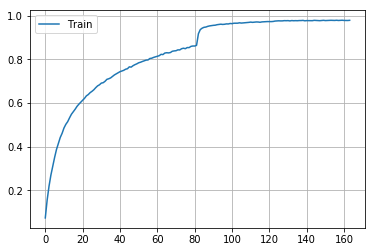

In [29]:
resnet = CifarResNet()
%time train_network(resnet, torch.device(DEVICE), a_lr = 0.01)

# Важно переключить сеть в режим eval - иначе dropout будет работать некорректно

In [30]:
def make_solution(a_net, a_device):
    res = []
    net = a_net.eval()
    for item in dataloader_test_norm:
        inputs = item.to(a_device)
        outputs = net(inputs) 

        res += prediction2classes(outputs)
    return res

In [31]:
# my_solution = make_solution(dense_net, DEVICE)
my_solution = make_solution(resnet, DEVICE)

In [32]:
with open('my_solution.csv', 'w') as fout:
    print('Id', 'Prediction', sep=',', file=fout)
    for i, prediction in enumerate(my_solution):
        print(i, prediction, sep=',', file=fout)